# Module 2 - Frequent pattern mining

## FPM Objectives:
1. Find combinations of attributes that are common to many objects
2. find significant associations between these combinations
3. Find frequent sequences

Definitions:
- $I$ is the set of all items $i_1, ..., i_n$, where $n$ is the number of items
- $S \in I$ is an itemset
- $D$ is a set of transactional data
- The support of an itemset in D is defined as: $sup_D(S) = \frac{\sum_{T \in D} \delta(S \subseteq T)}{|D|}$. It is the ratio between the number of transactions in which the given itemset is present and the total number of transactions. (during the slides, it is not taken as a ratio, but as just the numerator.)
- where $\delta$ is:
$$
\begin{equation}
\delta(x)=
    \begin{cases}
        1 & \text{if } x = true\\
        0 & \text{if } x = false
    \end{cases}
\end{equation}
$$
- The total number of itemsets is $2^{|I|} - 1$
- **Frequent Itemset Mining**: Given a set of items $I$, transactional data $D$ and a threshold value $\sigma$, FIM aims to find those itemsets called "frequent itemsets" which are generated from $I$, in which support in T is $\ge \sigma$ 

Naively computing these frequent itemsets is unfeasible, as the number of producable itemsets grows exponentally with the number of items in $I$. Thankfully, there are multiple ways to limit the search space for this purpose.

## 2 Theorems of Monotonicity

1. $sup_D(S) \ge \sigma \Rightarrow \text{all subsets of } S \text{ are frequent too}$
2. $sup_D(S) \lt \sigma \Rightarrow \text{all supersets of } S \text{ are non-frequent too}$

Now we'll move on to some algorithms for frequent itemset mining which utilize these theorems.

## Apriori

The code below is based on the data here:

|   TID   |             Items             |
|---------|------------------------------|
| Andrew  | Indian, Mediterranean        |
| Bernhard| Indian, Oriental, Fast Food   |
| Carolina| Indian, Mediterranean, Oriental|
| Dennis  | Arabic, Mediterranean        |
| Eve     | Oriental                     |
| Fred    | Indian, Mediterranean, Oriental|
| Gwyneth | Arabic, Mediterranean        |
| Hayden  | Indian, Oriental, Fast Food   |
| Irene   | Indian, Mediterranean, Oriental|
| James   | Arabic, Mediterranean        |


In [24]:
from typing import Set, Tuple
from itertools import product
from functools import reduce, partial
from operator import or_

# Sample transaction data with frozensets
t_data = [
    ('Andrew', frozenset(['Indian', 'Mediterranean'])),
    ('Bernhard', frozenset(['Indian', 'Oriental', 'Fast Food'])),
    ('Carolina', frozenset(['Indian', 'Mediterranean', 'Oriental'])),
    ('Dennis', frozenset(['Arabic', 'Mediterranean'])),
    ('Eve', frozenset(['Oriental'])),
    ('Fred', frozenset(['Indian', 'Mediterranean', 'Oriental'])),
    ('Gwyneth', frozenset(['Arabic', 'Mediterranean'])),
    ('Hayden', frozenset(['Indian', 'Oriental', 'Fast Food'])),
    ('Irene', frozenset(['Indian', 'Mediterranean', 'Oriental'])),
    ('James', frozenset(['Arabic', 'Mediterranean'])),
]

# Set of item types
all_items = {'Oriental', 'Indian', 'Mediterranean', 'Fast Food', 'Arabic'}

TransactionalData = Set[Tuple[str, Set[str]]]
ItemSet = Set[str]

# Remove comment in end of line if you want the support normalized
def support(t_data: TransactionalData, item_set: ItemSet):
    return len(list(item_set for _,v in t_data if item_set <= v)) / len(t_data)

def apriori(t_data: TransactionalData, items: ItemSet, sigma: float):
    """Return frequent itemsets for a minimum support threshold sigma"""
    F = {}
    C = {}
    supD = partial(support, t_data)
    k = 1
    # Create initial entry for F with sets of single items
    F[k] = {frozenset([i]) for i in items if supD(frozenset([i])) >= sigma}
    while F[k]:
        C[k+1] = generate_candidates(F[k], k + 1)
        F[k+1] = {X for X in C[k+1] if supD(X) >= sigma}
        k += 1
    return reduce(or_, list(F.values()), set())

def generate_candidates(F: Set[ItemSet], k: int):
    """Create new itemsets which will be supersets of the elements
    in the last phase of k. Only union if result is of length k"""
    C = {X | Y for X,Y in product(F, F) if len(X | Y) == k}
    return C
    # Whatever the fuck this is
    # return {X for X in C if all(len(Y) == k - 1 for Y in X)}

apriori(t_data, all_items, 0.3) # You get same supported elements as the lattice in page 10 of the lectures

{frozenset({'Arabic', 'Mediterranean'}),
 frozenset({'Indian'}),
 frozenset({'Mediterranean'}),
 frozenset({'Indian', 'Mediterranean'}),
 frozenset({'Oriental'}),
 frozenset({'Mediterranean', 'Oriental'}),
 frozenset({'Indian', 'Oriental'}),
 frozenset({'Indian', 'Mediterranean', 'Oriental'}),
 frozenset({'Arabic'})}

## Eclat

Instead of storing items in the previous format, eclat stores them in a vertical one, so that checking the support for an itemset of , e.g. cardinality 2, once you have this data format simply becomes a task of finding the cardinality of the intersection between the 2 TID-sets of the items of the itemset.

| Item          | TID-set                              | Cardinality |
| ------------- | ------------------------------------ | ----------- |
| Arabic        | {Dennis, Gwyneth, James}              | 3           |
| Indian        | {Andrew, Bernhard, Carolina, Fred, Hayden, Irene} | 6           |
| Mediterranean | {Andrew, Carolina, Dennis, Fred, Gwyneth, Irene, James} | 7           |
| Oriental      | {Bernhard, Carolina, Eve, Fred, Hayden, Irene} | 6           |
| Fast Food     | {Bernhard, Hayden}                    | 2           |

So support for $\{I, M\}$ (im referring to items by their first letter) is $|\{Andrew, Bernhard, Carolina, Fred, Hayden, Irene\}\cap\{Andrew, Carolina, Dennis, Fred, Gwyneth, Irene, James\}|$, which is 4. It works similarly to Apriori, in the sense that it starts with cardinality k = 1, and then iteratively increases k and performs intersections on TID-sets in order to check for support, and if the support for a combination is good, it keeps it, if not, it drops it.

## FPGrowth

This is an algorithm which utilizes a data structure called an FPTree, which stores the supports and occurences of objects after one another in a tree. I have implemented an FPTree building algorithm, but not FPGrowth itself as i found it very confusing. 

In [23]:
from collections import Counter
from pprint import pprint
from typing import Dict, List, Set

t_data: TransactionalData = [
    ('Andrew', frozenset(['Indian', 'Mediterranean'])),
    ('Bernhard', frozenset(['Indian', 'Oriental', 'Fast Food'])),
    ('Carolina', frozenset(['Indian', 'Mediterranean', 'Oriental'])),
    ('Dennis', frozenset(['Arabic', 'Mediterranean'])),
    ('Eve', frozenset(['Oriental'])),
    ('Fred', frozenset(['Indian', 'Mediterranean', 'Oriental'])),
    ('Gwyneth', frozenset(['Arabic', 'Mediterranean'])),
    ('Hayden', frozenset(['Indian', 'Oriental', 'Fast Food'])),
    ('Irene', frozenset(['Indian', 'Mediterranean', 'Oriental'])),
    ('James', frozenset(['Arabic', 'Mediterranean'])),
]

# Set of item types
all_items: ItemSet = {'Oriental', 'Indian', 'Mediterranean', 'Fast Food', 'Arabic'}

class FPTreeNode:
    children: List['FPTreeNode']
    key: str
    count: int
    header_table: Dict[str, 'HeaderTableEntry']
    order: List[str]

    def copy(self, header_table) -> 'FPTreeNode':
        children = [child.copy() for child in self.children]
        copied = FPTreeNode(self.key, header_table, self.order.copy())
        copied.children = children
        return copied

    def __init__(self, key: str, header_table: Dict[str, 'HeaderTableEntry'], order: List[str]):
        self.children = []
        self.key = key 
        self.count = 1
        self.header_table = header_table
        self.order = order

    def pick_next_from_order(self, values: Set[str]):
        for o in self.order:
            if o in values:
                values.remove(o)
                return o

    def find_child(self, key: str) -> 'FPTreeNode':
        return next(x for x in self.children if x.key == key)

    def insert_set(self, items: ItemSet):
        if inter := set([x.key for x in self.children]) & items:
            inter = set(inter)
            child = self.find_child(self.pick_next_from_order(inter))
            child.count += 1
            child.insert_set(items - {child.key})
        elif items and not set([x.key for x in self.children]) & items:
            items = set(items)
            new_child = FPTreeNode(self.pick_next_from_order(items), self.header_table, self.order)
            self.children.append(new_child)
            hdr_entry = self.header_table.get(new_child.key, None)
            if hdr_entry:
                hdr_entry.insert_node(new_child)
            else:
                self.header_table[new_child.key] = HeaderTableEntry([new_child])
            new_child.insert_set(items)
    
    def __str__(self) -> str:
        return f"{self.key} : {self.count} -> {self.children}"

    def __repr__(self) -> str:
        return str(self)

class HeaderTableEntry:
    nodes: List[FPTreeNode]
    count: int

    def __init__(self, nodes=[]) -> None:
        self.nodes = nodes
        self.count = 0
    
    def insert_node(self, node):       
        self.nodes.append(node)
    
    def recompute_count(self):
        self.count = sum(node.count for node in self.nodes)

    def __str__(self) -> str:
        return f"Nodes: {[node.key + ' : ' + str(node.count) for node in self.nodes]}, support: {self.count}"
    
    __repr__ = __str__


class FPTree:
    root_node: FPTreeNode
    header_table: Dict[str, HeaderTableEntry]
    order: List[str]

    def __init__(self):
        self.header_table = {}
        self.root_node = None
        self.order = None
        pass

    def populate_tree(self, t_data: TransactionalData, sigma: int):
        # Pass 1: Get support for all items
        supports = Counter()
        for _, items in t_data:
            supports.update(items)

        # Filter useless supports, get supp in desc. order
        useful_supports = sorted([item for item in supports.items() if item[1] >= sigma], key=lambda x: -x[1])
        useless_supports = set(item[0] for item in supports.items() if item[1] < sigma)
        self.order = [elem for elem,_ in useful_supports]

        self.header_table = {}
        self.root_node = FPTreeNode('{}', self.header_table, self.order)
        # Construct FPTree
        for _, items in t_data:
            self.root_node.insert_set(items - useless_supports)
        # Get final header values
        for entry in self.header_table.values():
            entry.recompute_count()

tree = FPTree()
tree.populate_tree(t_data, 3)
print(f"Tree nodes (formatted [$key : $count -> [$children]]): {tree.root_node.children}")
print(f"Tree header:")
pprint(tree.header_table)


Tree nodes (formatted [$key : $count -> [$children]]): [Mediterranean : 7 -> [Indian : 4 -> [Oriental : 3 -> []], Arabic : 3 -> []], Indian : 2 -> [Oriental : 2 -> []], Oriental : 1 -> []]
Tree header:
{'Arabic': Nodes: ['Arabic : 3'], support: 3,
 'Indian': Nodes: ['Indian : 4', 'Indian : 2'], support: 6,
 'Mediterranean': Nodes: ['Mediterranean : 7'], support: 7,
 'Oriental': Nodes: ['Oriental : 2', 'Oriental : 3', 'Oriental : 1'], support: 6}


Ultimately, this is the FP tree we constructed: 

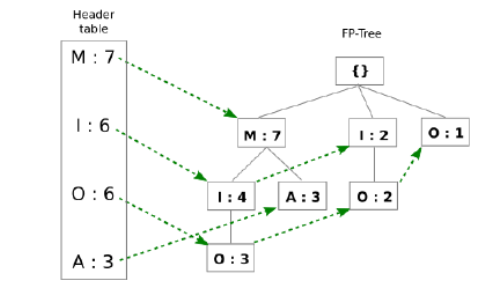

## FPGrowth

FPGrowth is used to find all frequent itemsets that have a certain element inside them quickly. 

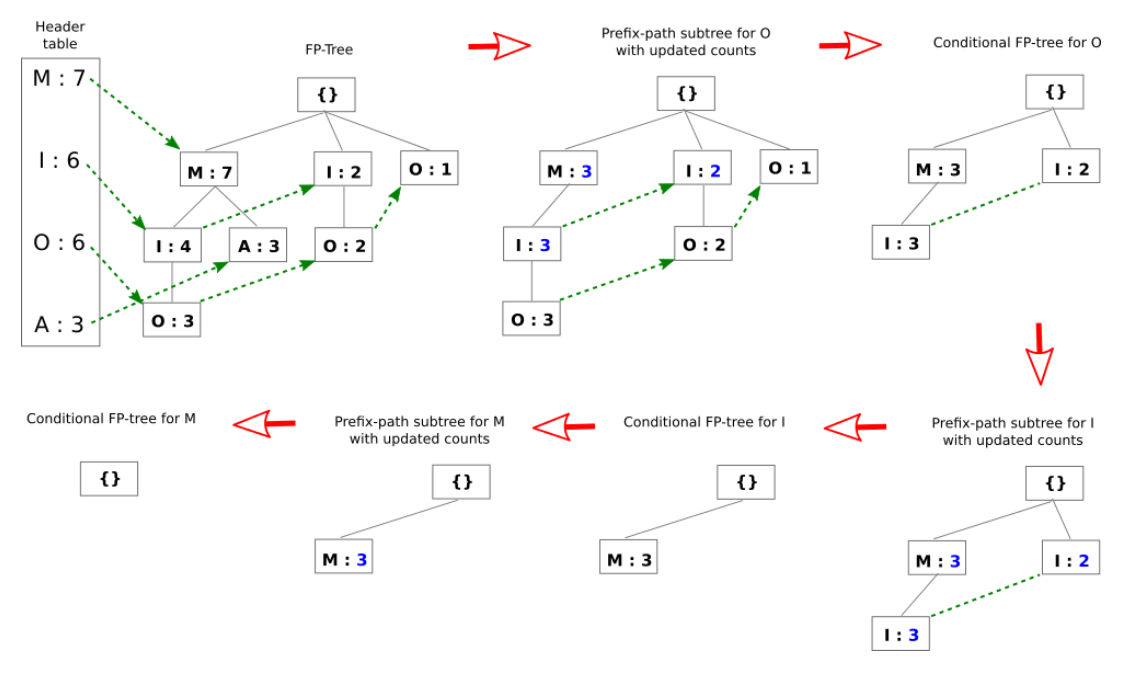

Explaination from the book for the picture above:

The picture above illustrates the process of finding frequent itemsets, given $\sigma = 3$,
ending in item O but not containing A.2 FPGrowth starts at the leaves of the tree
containing item O. First, it extracts all the paths in the tree ending in O by following the
links from O in the header table and keeping only those nodes that are on direct paths from
these leaves to the root node. The resulting subtree is called the prefixpath subtree for
O.
Checking the support of O by summing the counts along the leaves gives $3 + 2 + 1 = 6$,
so the itemset $\{O\}$ is frequent and is added to the result. In the next step, the counts of the
nodes in the prefixpath subtree are updated, reflecting the number of transactions
containing O.
In the next step, as $\{O\}$ was frequent, itemsets ending in O are searched for. For this
reason, a socalled conditional FPtree is created from the prefixpath subtree for O by
simply cutting all the leaves with O and removing all the items the count of which,
summed up by chasing the corresponding links from the header table, does not reach the
$\sigma$
threshold. In our case, the counts of all the resulting items I and M are greater
or equal to 3, so no items are deleted. The resulting conditional FPtree represents those
itemsets that appear in transactions together with O, together with their support.
This procedure is applied recursively to the resulting conditional FPtree of O: a
prefixpath subtree for I is created and the counts are updated. The sum of the nodes
containing I is $3 + 2 = 5$, so I is added to existing itemsets in the result, forming the
frequent itemset {I,O}. Again, recursively, a prefixpath subtree for M is created in
which the count for M is 3, so M is added to the existing frequent itemsets $\{O\}$ and $\{I,O\}$
resulting in new itemsets $\{M,O\}$ and $\{M,I,O\}$, respectively. Since the conditional FP
tree for M is empty, the generation of itemsets ending in item O stops, resulting in frequent
itemsets $\{M,I,O\}$, $\{M,O\}$, $\{I,O\}$ and $\{O\}$.

## Maximal and closed frequent itemsets

1. **Maximal itemset**: A frequent itemset is maximal if none of its supersets is frequent
2. **Closed itemset**: A frequent itemset is minimal if none of its supersets has the same support

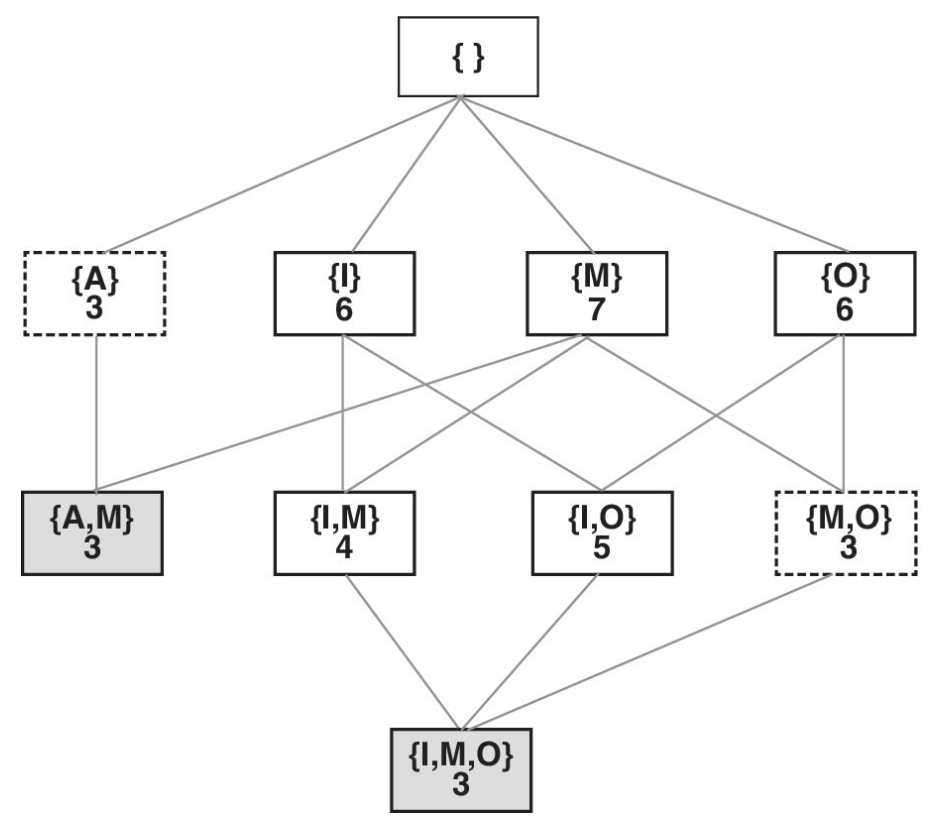

Maximal (shaded) and closed (with solid edges) itemsets generated from the data in the tables above

## Association Rule

An association rule is an implication of the form $A \Rightarrow C$, where $A$ and $C$ are itemsets that do not share common items. $A$ is called the antecedent of the rule and $C$ is called the conseqent. The meaning of an association rule is that if its antecedent is present in some transactions then
its consequent should also be present in these transactions. 

The support for an association rule is defined as such:
$$
    support(A \Rightarrow C) = support(A \cup C)
$$

So according to the data, the support of the rule $\{A\} \Rightarrow \{M\}$ is the support of
the itemset $\{A,M\}$, created by joining the antecedent and the consequent of the rule, which
is equal to 3. It is important to notice that the support of the rule $\{A\} \Rightarrow \{M\}$ is the same
as of the rule $\{M\} \Rightarrow \{A\}$.

The support is a kind of a quantity or frequency measure, but it is not enough to measure the
quality of a rule. The reason is that it gives the same value when we exchange the antecedent
and the consequent of a rule. The quality, or the reliability, of a rule can be measured by its
confidence, defined as the ratio of the support of the rule to the support of the antecedent of the
rule:
$$
    confidence(A \Rightarrow C) = \frac{support(A \cup C)}{support(A)}
$$

## Association rule mining

Given an itemset $I$, a dataset $D$ and the threshold values $\sigma, \theta$, which are respectively the support and confidence threshold, find the association rules $A \Rightarrow C$ such as:
$$
    sup_D(A \Rightarrow C) \ge \sigma \\
    conf_D(A \Rightarrow C) \ge \theta
$$

The number of association rules we can generate is $3^{|I|} - 2^{|I|+1} + 1$. So it's the number of different splits into A and C, minus the rules with empty antecedents and consequents, minus a rule with empty antecedent and consequent (the empty rule)

### Monotonicity for association rules

$\text{conf}_D(X \Rightarrow Y - X) < \theta \Rightarrow \text{conf}_D(X' \Rightarrow Y - X') < \theta$

Where $X$ and $Y$ are itemsets, and $X'$ is a subset of X. 

In other words, the theorem says that if the confidence of the rule does not satisfy the $\theta$
threshold and we modify this rule by moving one or more items from its
antecedent into its consequent, then the confidence of the modified rule will not satisfy the $\theta$
threshold, either. Using this theorem we can define a systematic algorithm to
generate association rules for a given frequent itemset $Z$ in the following way:

In [33]:
def confidence(t_data, A: Set[str], C: Set[str]) -> float:
    return round(support(t_data, A | C) / support(t_data, A), 2) # rounding because it computed one element that should have been 0.75 as 0.749999999

def assoc_rule_generation(t_data, Z: Set[str], min_conf: int) -> Set[ItemSet]:
    k = 1
    C = {1:set()}
    conf_D = partial(confidence, t_data)
    for i in Z:
        if conf_D(Z - {i}, {i}) >= min_conf:
            C[k].add(frozenset({i}))
    k = 2
    while True:
        C[k] = set()
        for V in generate_candidates(C[k-1], k):
            if conf_D(Z - V, V) >= min_conf:
                C[k].add(frozenset({V}))
        k += 1
        if k >= len(Z) - 1:
            break 
    return reduce(or_, list(C.values()), set())

assoc_rule_generation(t_data, {'Indian', 'Mediterranean', 'Oriental'}, 0.75)

{frozenset({'Indian'}), frozenset({'Oriental'})}

## Cross-support pattern

If a pattern contains lowsupport items and highsupport items, then it is called a cross
support pattern. the support ratio is a metric that helps us determine whether a pattern is a cross-support one or not. 

$$
sup\_ratio(P) = \frac{min\{s(i_1), ..., s(i_k)\}}{max\{s(i_1), ..., s(i_k)\}}
$$

This measure can be used to filter out patterns with $sup\_ratio$ below or above a user
specified threshold, depending on the interest of a given user.

In [ ]:
def support_ratio(P: ItemSet) -> float:
    return min(P) / max(P)

## Lift

$$
    lift(X \Rightarrow Y) = \frac{confidence(X \Rightarrow Y)}{support(Y)}
$$

The lift values are greater than or equal to zero, and:
- A lift value greater than 1 indicates a positive correlation between the rule's antecedent and
consequent; that is, the occurrence of the antecedent has a positive effect on the occurrence
of the consequent.
- A lift value smaller than 1 indicates a negative correlation between the rule's antecedent
and consequent; that is, the occurrence of the antecedent has a negative effect on the
occurrence of the consequent.
- A lift value near 1 indicates that there is no correlation between the rule's antecedent and
consequent; that is, the occurrence of the antecedent has almost no effect on the occurrence
of the consequent

### Simpson's paradox

certain correlations between pairs of itemsets (antecedents and
consequents of rules) appearing in different groups of data may
disappear or be reversed when these groups are combined